In [3]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [4]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [5]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [6]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [7]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 5)
Y = np.random.uniform(-5, 5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
}).round(3)


In [8]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [9]:
df

x      y        z
0 -0.830 -4.077 -284.254
1  2.203 -3.137 -111.670
2 -4.999 -1.544 -247.301
3 -1.977 -1.032 -128.723
4 -3.532  0.388 -111.174

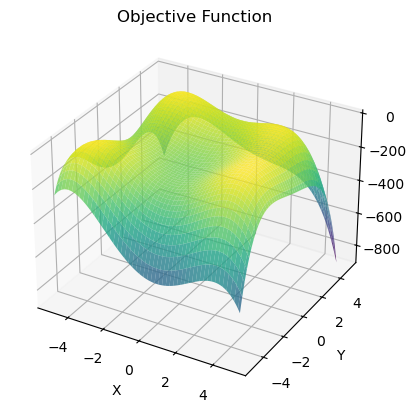

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [11]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [12]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  2, "Z": benchmark(0,  0)},
    {"X": -2.805, "Y":  3.131, "Z": benchmark(0,  0)},
    {"X": -3.779, "Y":  -3.283, "Z": benchmark(0,  0)},
    {"X": 3.584, "Y":  -1.848, "Z": benchmark(0,  0)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y    Z
0  3.000  2.000 -170
1 -2.805  3.131 -170
2 -3.779 -3.283 -170
3  3.584 -1.848 -170

In [13]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 5, 100)
    y_range = np.linspace(-5, 5, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 75
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # # Train the model with the best hyperparameters on the entire dataset
    # best_model = NN_model(
    #     num_layers=result.x[0],
    #     num_units=result.x[1],
    #     learning_rate=result.x[2],
    #     dropout_rate=result.x[3]
    # )

    # # Standardize the Dataset of Simulation Responses
    # scaler_x = StandardScaler().fit(sim_df[['x', 'y']])
    # X_scaled = scaler_x.transform(sim_df[['x', 'y']])

    # # Train the best model on the combined standardized dataset
    # best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    
    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=6,
        num_units=300,
        learning_rate=0.01,
        dropout_rate=0.2
    )

    # Standardize the initial dataset
    # scaler_x = StandardScaler().fit(df[['x', 'y']])
    # X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(sim_df[['x','y']], sim_df[['sim_z']], epochs=500, batch_size=128, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 5)]
    y_range = [(-5, 5)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy)  # Get mean & uncertainty
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])
        existing_points = set(tuple(row) for row in df[['x', 'y']].values)

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        while len(output) < sample_size:
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            
            xy_tuple = tuple(xy[0])
            
            if xy_tuple not in existing_points:
                output = np.vstack((output, xy))  # Stack valid samples
                existing_points.add(xy_tuple)  # Add new point to the set

        return output  # Returns an array of shape (sample_size, 2)

    # Use Metropolis-Hastings to sample new experimental points
    X_mh = mh_sampler(sig=8, sample_size=5, burn_in=50, lag=20)

    # Convert MH samples to a DataFrame
    physical_test_points = pd.DataFrame(X_mh, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(5, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 4.34126764 -2.96679078]


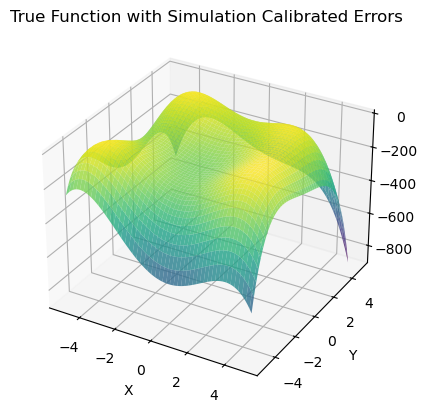

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 31171.2617
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 25710.1367
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 64794.8047
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21643.0840
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 29559.1309
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 30763.9492
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 30947.3945
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 30958.6758
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 30892.7559
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 30772.6934
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 30446.7383
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 29819.5117
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 28502.0684
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 26685.6836
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

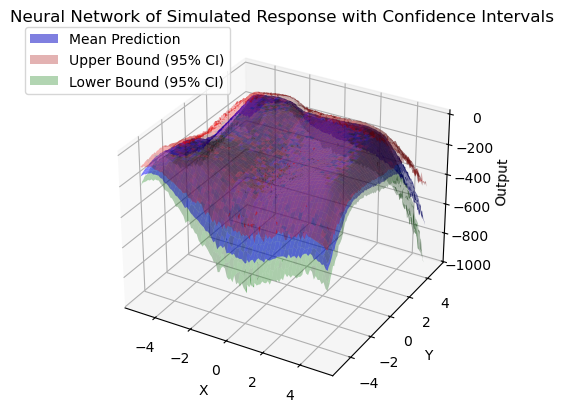

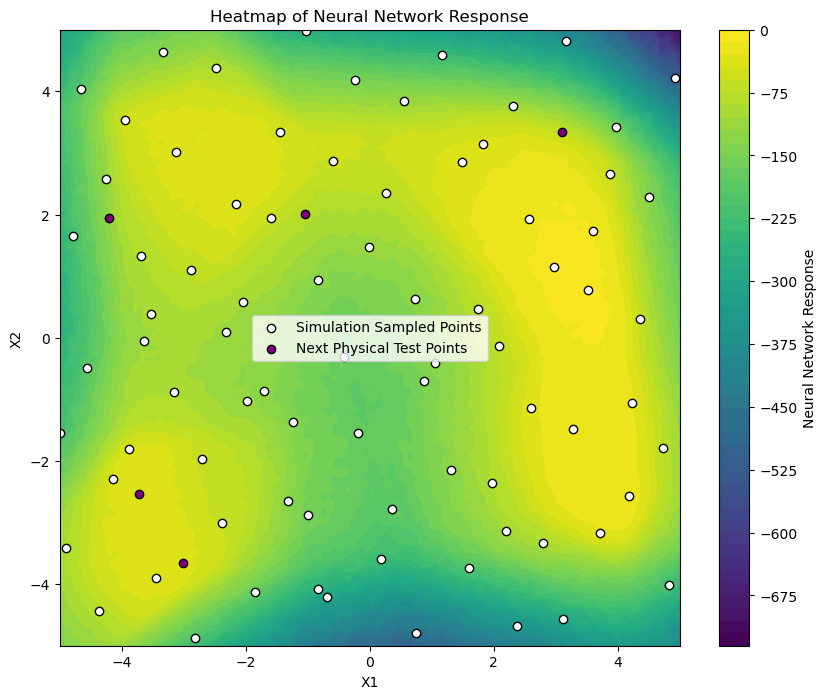

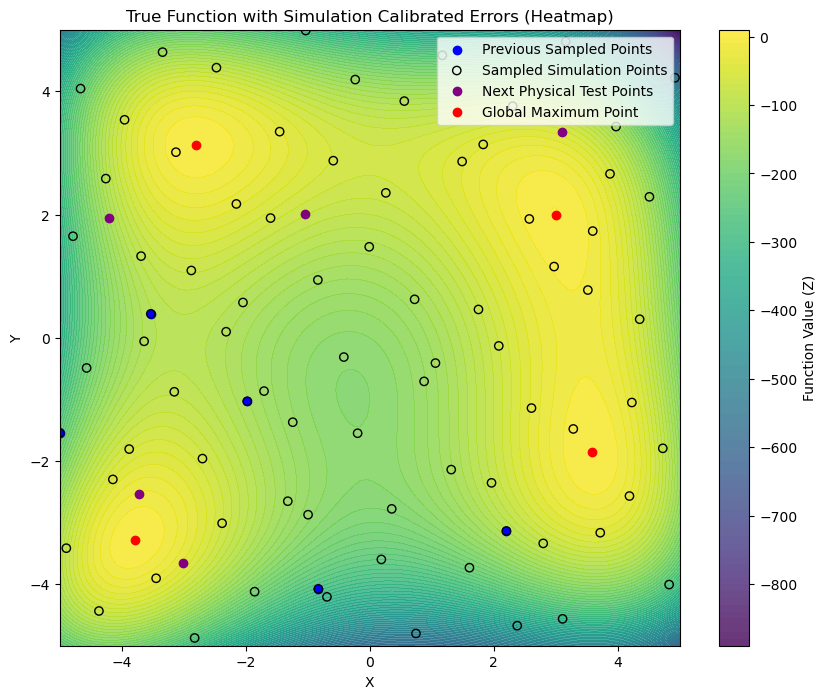

          x         y           z         a         b       sim_z      diff
0 -0.830000 -4.077000 -284.254000  4.341268 -2.966791 -284.470590  0.216590
1  2.203000 -3.137000 -111.670000  4.341268 -2.966791 -111.975321  0.305321
2 -4.999000 -1.544000 -247.301000  4.341268 -2.966791 -247.182800 -0.118200
3 -1.977000 -1.032000 -128.723000  4.341268 -2.966791 -128.556343 -0.166657
4 -3.532000  0.388000 -111.174000  4.341268 -2.966791 -111.307736  0.133736
5 -3.715599 -2.535733  -18.449523  4.341268 -2.966791  -18.254239 -0.195284
6 -3.015836 -3.657943  -42.370777  4.341268 -2.966791  -41.995469 -0.375309
7  3.106134  3.346672  -57.324149  4.341268 -2.966791  -56.906329 -0.417820
8 -1.047407  2.006722  -78.526449  4.341268 -2.966791  -78.587613  0.061164
9 -4.206991  1.951527 -129.578588  4.341268 -2.966791 -129.930603  0.352015


In [14]:
df = perform_iteration(df)
print(df)


[ 4.16604217 -3.21990397]


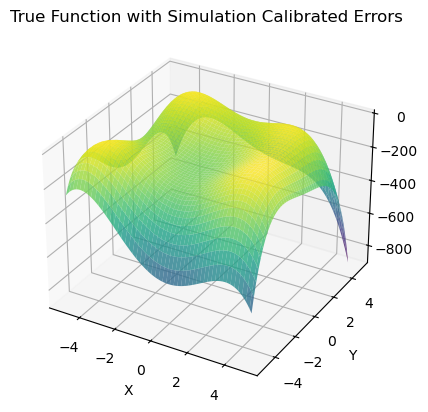

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 30350.9492
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 25656.1934
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 49527.5820
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 22314.8320
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 28934.1934
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 29942.2168
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 30126.8184
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 30136.1289
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 30087.6504
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 29950.5527
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 29723.4609
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 29033.7266
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 27604.0762
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 24194.1582
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

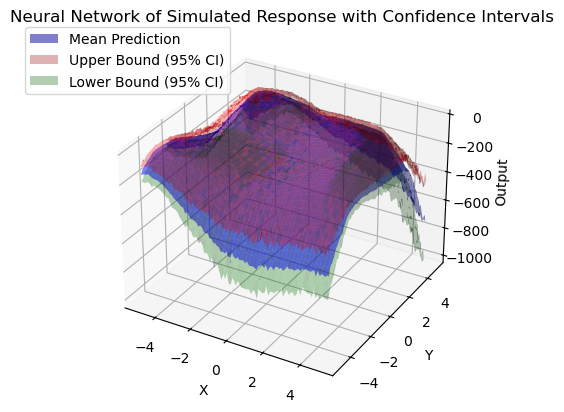

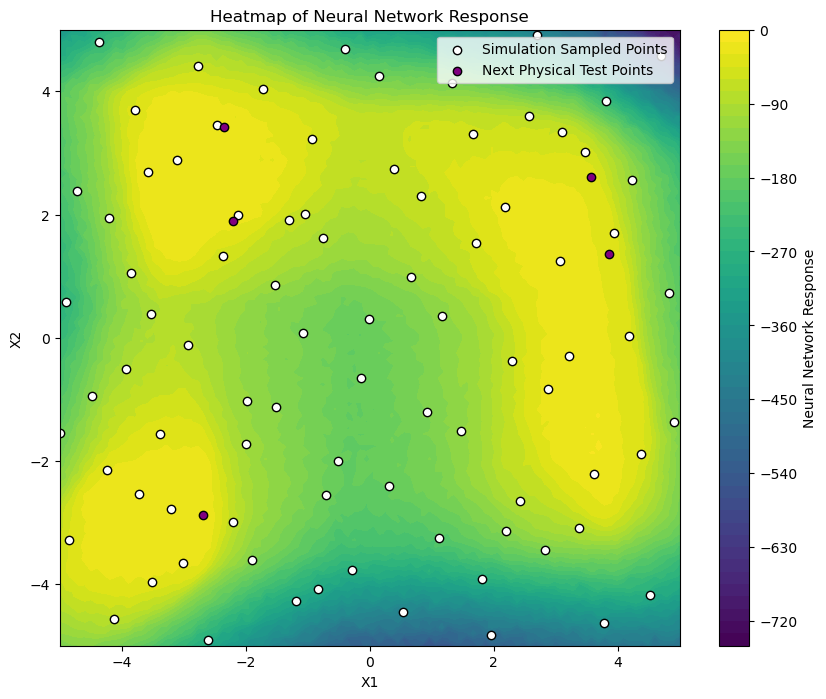

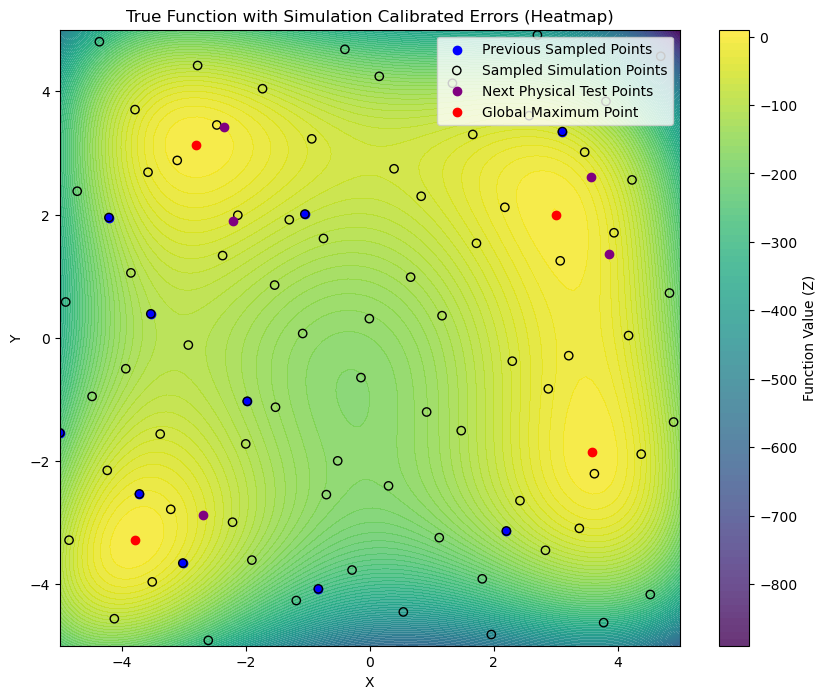

In [15]:
df = perform_iteration(df)

[ 3.98870766 -3.24293724]


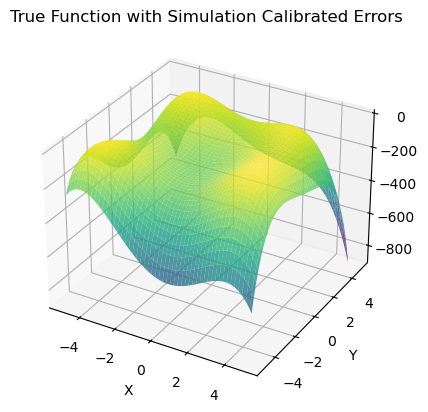

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 29363.4941
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 20736.4434
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 283847.3438
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 16297.6475
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 27300.3438
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 29022.9590
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 29246.7188
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 29254.3340
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 29177.0020
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 29037.7617
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 28769.0312
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 28230.0391
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 26885.2383
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 24096.6836
Epoch 15/500
1/1 ━━━━━━━━━━━━━

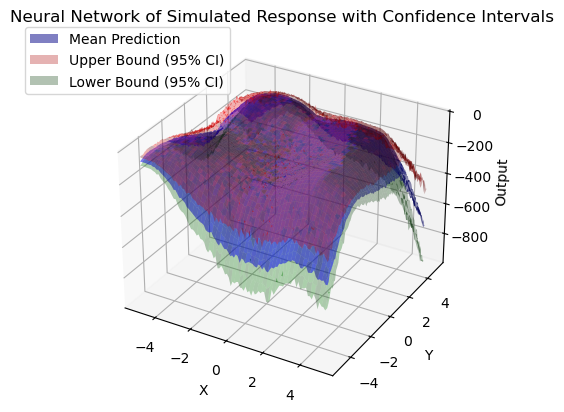

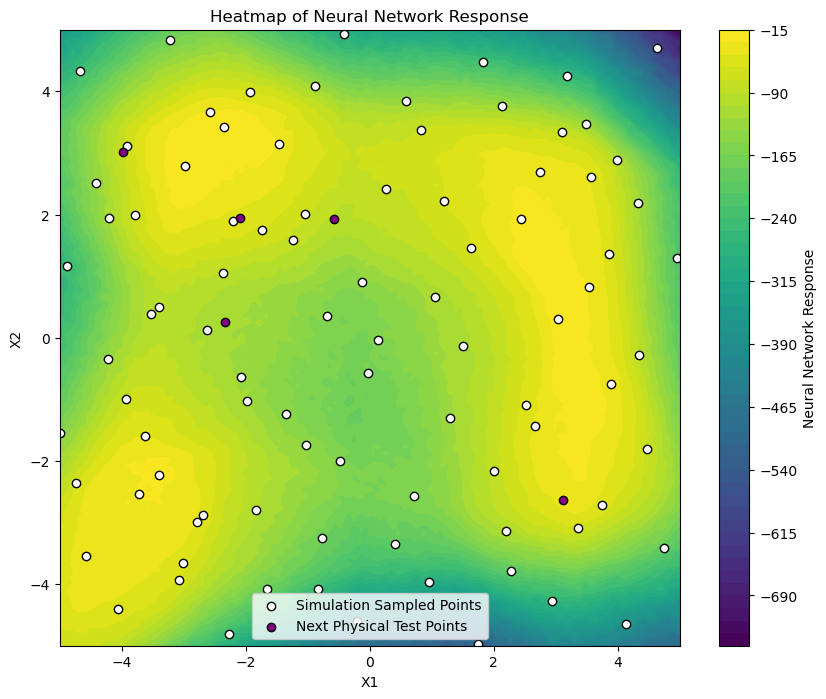

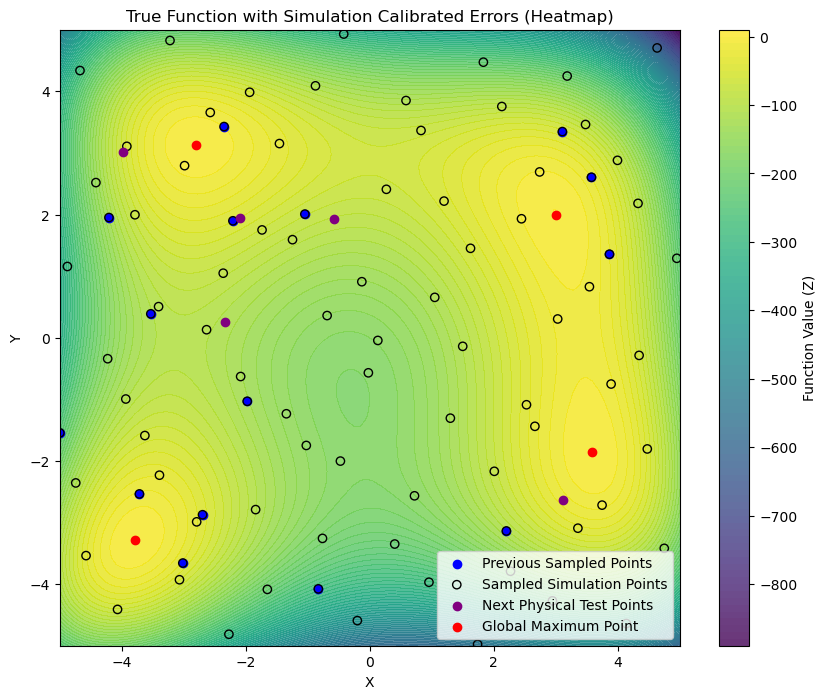

           x         y           z         a         b       sim_z      diff
0  -0.830000 -4.077000 -284.254000  3.988708 -3.242937 -277.195869 -7.058131
1   2.203000 -3.137000 -111.670000  3.988708 -3.242937 -106.067415 -5.602585
2  -4.999000 -1.544000 -247.301000  3.988708 -3.242937 -249.027955  1.726955
3  -1.977000 -1.032000 -128.723000  3.988708 -3.242937 -129.224763  0.501763
4  -3.532000  0.388000 -111.174000  3.988708 -3.242937 -113.325421  2.151421
5  -3.715599 -2.535733  -18.449523  3.988708 -3.242937  -17.468913 -0.980609
6  -3.015836 -3.657943  -42.370777  3.988708 -3.242937  -37.687110 -4.683667
7   3.106134  3.346672  -57.324149  3.988708 -3.242937  -50.127399 -7.196750
8  -1.047407  2.006722  -78.526449  3.988708 -3.242937  -77.379392 -1.147057
9  -4.206991  1.951527 -129.578588  3.988708 -3.242937 -130.602283  1.023695
10 -2.697444 -2.873441  -45.654203  3.988708 -3.242937  -43.244577 -2.409626
11 -2.207551  1.898308  -49.224003  3.988708 -3.242937  -49.096619 -0.127384

In [16]:
df = perform_iteration(df)
print(df)

[ 3.92910399 -3.02367176]


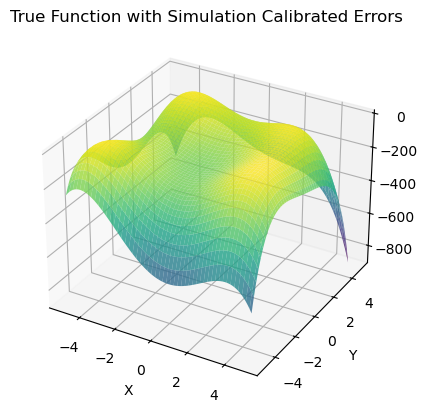

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 26934.5312
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 17403.7129
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 418192.9375
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 13158.8320
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 24796.1797
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 26585.2793
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 26828.7422
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 26853.4316
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 26813.4023
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 26709.5859
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 26290.0840
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25292.6797
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 22489.6953
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18002.8320
Epoch 15/500
1/1 ━━━━━━━━━━━━━

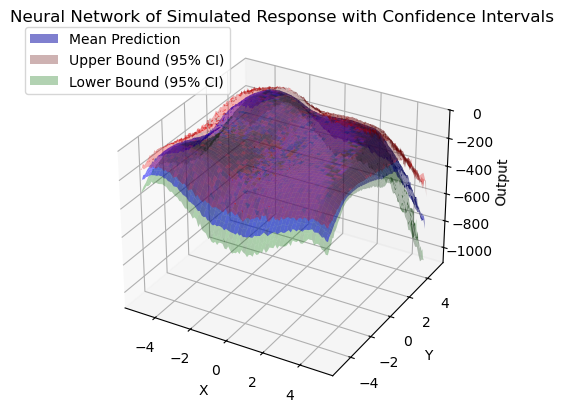

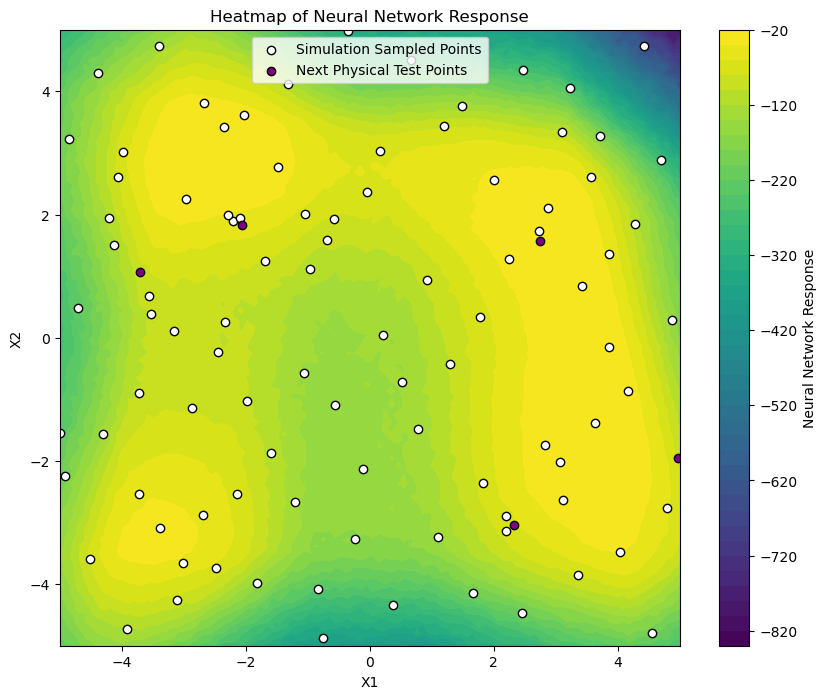

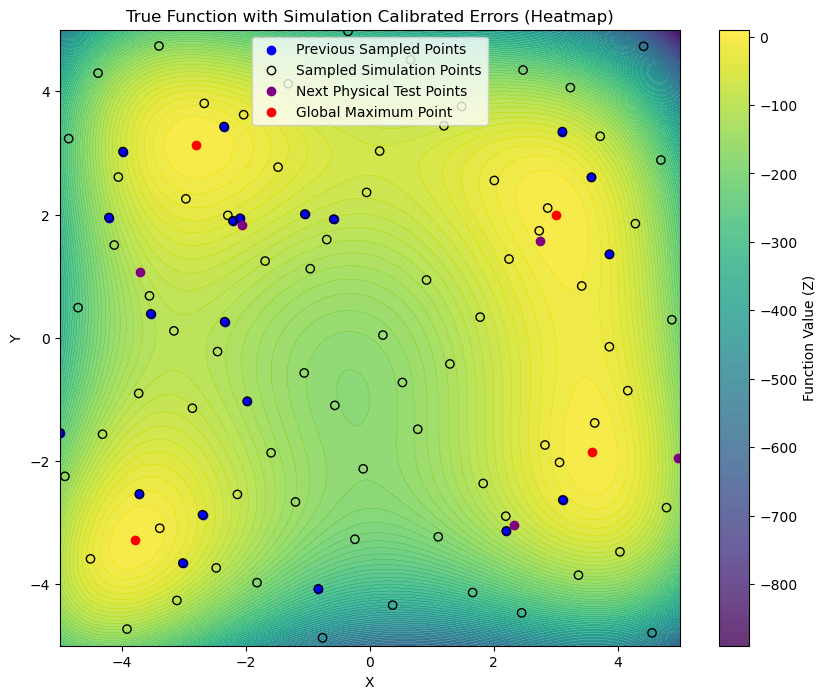

           x         y           z         a         b       sim_z      diff
0  -0.830000 -4.077000 -284.254000  3.929104 -3.023672 -284.332183  0.078183
1   2.203000 -3.137000 -111.670000  3.929104 -3.023672 -111.898242  0.228242
2  -4.999000 -1.544000 -247.301000  3.929104 -3.023672 -247.151439 -0.149561
3  -1.977000 -1.032000 -128.723000  3.929104 -3.023672 -128.541923 -0.181077
4  -3.532000  0.388000 -111.174000  3.929104 -3.023672 -111.297539  0.123539
5  -3.715599 -2.535733  -18.449523  3.929104 -3.023672  -18.212315 -0.237208
6  -3.015836 -3.657943  -42.370777  3.929104 -3.023672  -42.035481 -0.335296
7   3.106134  3.346672  -57.324149  3.929104 -3.023672  -57.119398 -0.204751
8  -1.047407  2.006722  -78.526449  3.929104 -3.023672  -78.608572  0.082123
9  -4.206991  1.951527 -129.578588  3.929104 -3.023672 -129.850647  0.272059
10 -2.697444 -2.873441  -45.654203  3.929104 -3.023672  -45.431963 -0.222240
11 -2.207551  1.898308  -49.224003  3.929104 -3.023672  -49.441070  0.217066

In [17]:
df = perform_iteration(df)
print(df)

[ 3.93139    -3.10637063]


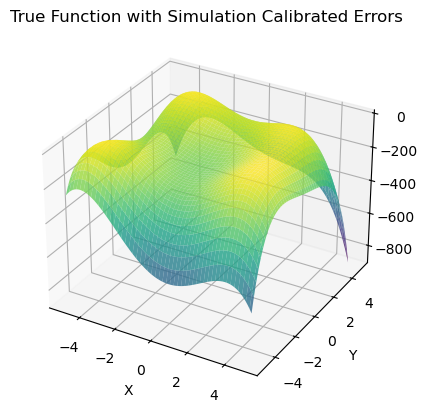

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 25520.4297
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 19751.4980
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 125572.3594
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 16268.7539
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 24174.8047
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 25244.7695
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25400.8184
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25411.1934
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25388.5898
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 25301.9922
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25140.3066
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 24657.5254
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 23586.1641
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21063.1309
Epoch 15/500
1/1 ━━━━━━━━━━━━━

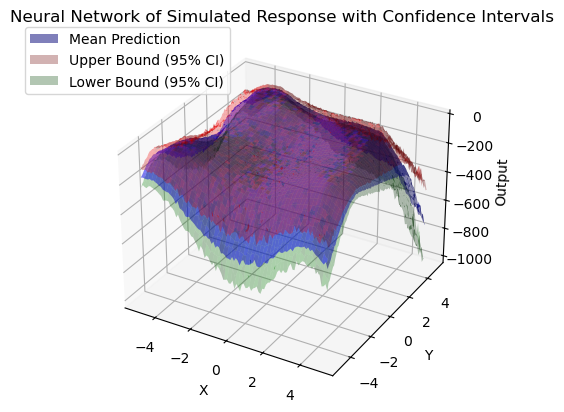

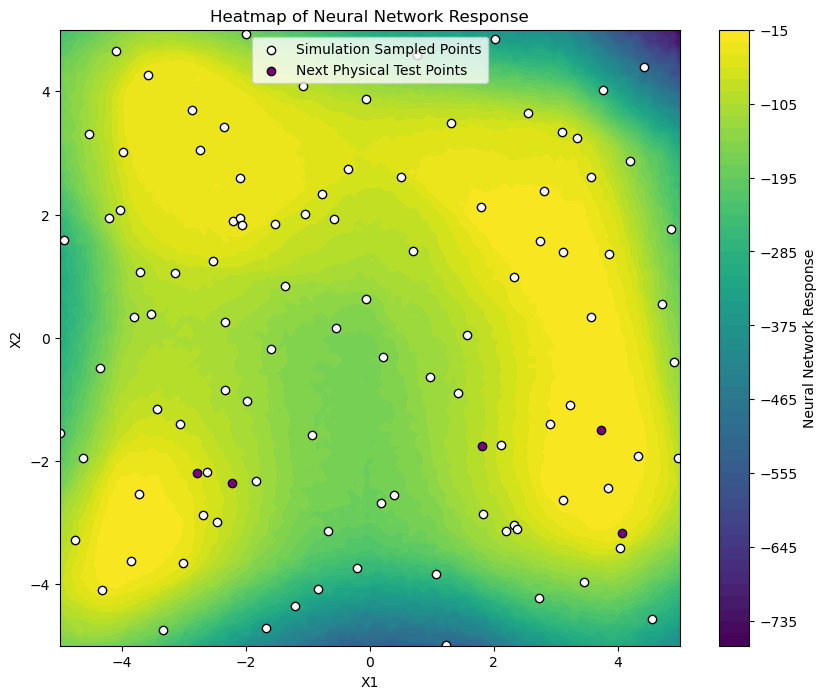

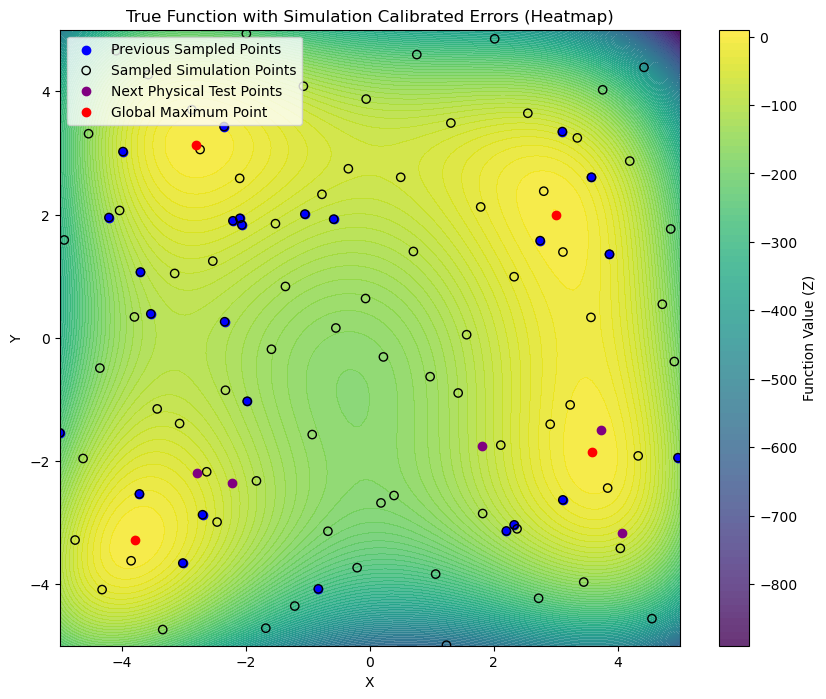

           x         y           z        a         b       sim_z      diff
0  -0.830000 -4.077000 -284.254000  3.93139 -3.106371 -284.103261 -0.150739
1   2.203000 -3.137000 -111.670000  3.93139 -3.106371 -111.831705  0.161705
2  -4.999000 -1.544000 -247.301000  3.93139 -3.106371 -247.010638 -0.290362
3  -1.977000 -1.032000 -128.723000  3.93139 -3.106371 -128.491061 -0.231939
4  -3.532000  0.388000 -111.174000  3.93139 -3.106371 -111.221450  0.047450
5  -3.715599 -2.535733  -18.449523  3.93139 -3.106371  -18.048841 -0.400682
6  -3.015836 -3.657943  -42.370777  3.93139 -3.106371  -41.796947 -0.573831
7   3.106134  3.346672  -57.324149  3.93139 -3.106371  -57.056566 -0.267583
8  -1.047407  2.006722  -78.526449  3.93139 -3.106371  -78.540874  0.014425
9  -4.206991  1.951527 -129.578588  3.93139 -3.106371 -129.710024  0.131436
10 -2.697444 -2.873441  -45.654203  3.93139 -3.106371  -45.268778 -0.385424
11 -2.207551  1.898308  -49.224003  3.93139 -3.106371  -49.351129  0.127126
12  3.865836

In [18]:
df = perform_iteration(df)
print(df)

[ 4.16400825 -3.00053735]


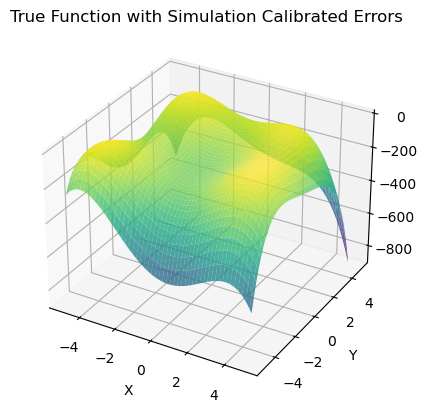

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 25443.5566
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 18922.3203
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 194824.0938
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 15215.1738
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 24057.9434
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25211.6387
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25359.9746
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25371.4590
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25347.7305
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25288.3301
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25152.9980
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 24858.7637
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 24183.9219
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 22211.8145
Epoch 15/500
1/1 ━━━━━━━━━━━━━

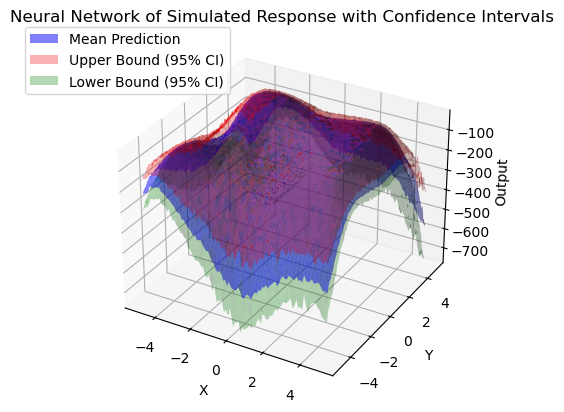

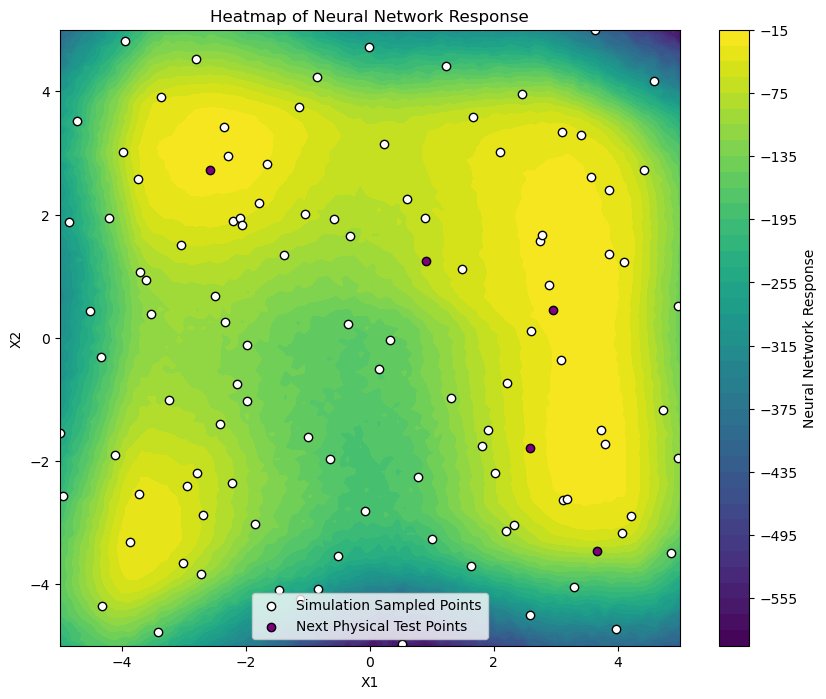

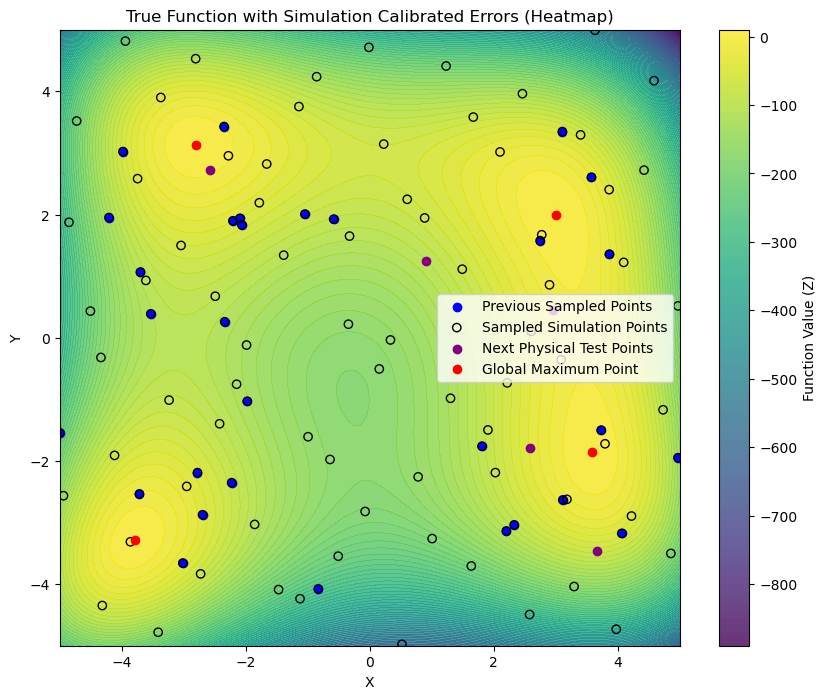

           x         y           z         a         b       sim_z      diff
0  -0.830000 -4.077000 -284.254000  4.164008 -3.000537 -284.402720  0.148720
1   2.203000 -3.137000 -111.670000  4.164008 -3.000537 -111.887821  0.217821
2  -4.999000 -1.544000 -247.301000  4.164008 -3.000537 -247.234951 -0.066049
3  -1.977000 -1.032000 -128.723000  4.164008 -3.000537 -128.567460 -0.155540
4  -3.532000  0.388000 -111.174000  4.164008 -3.000537 -111.346260  0.172260
5  -3.715599 -2.535733  -18.449523  4.164008 -3.000537  -18.290426 -0.159096
6  -3.015836 -3.657943  -42.370777  4.164008 -3.000537  -42.130446 -0.240331
7   3.106134  3.346672  -57.324149  4.164008 -3.000537  -57.098967 -0.225181
8  -1.047407  2.006722  -78.526449  4.164008 -3.000537  -78.630328  0.103879
9  -4.206991  1.951527 -129.578588  4.164008 -3.000537 -129.926351  0.347764
10 -2.697444 -2.873441  -45.654203  4.164008 -3.000537  -45.500018 -0.154184
11 -2.207551  1.898308  -49.224003  4.164008 -3.000537  -49.481203  0.257199

In [19]:
df = perform_iteration(df)
print(df)

[ 4.15767488 -3.00007484]


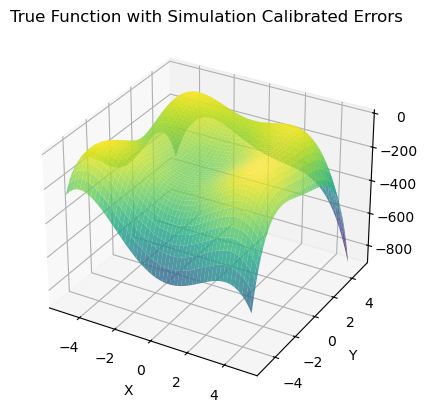

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 23883.8691
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18499.4961
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 111156.8203
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 15084.2305
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 22562.7812
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 23613.8730
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 23767.1211
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 23779.5781
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 23753.6953
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 23675.0645
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 23495.1113
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 23181.3105
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 22361.6152
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 21283.7344
Epoch 15/500
1/1 ━━━━━━━━━━━━━

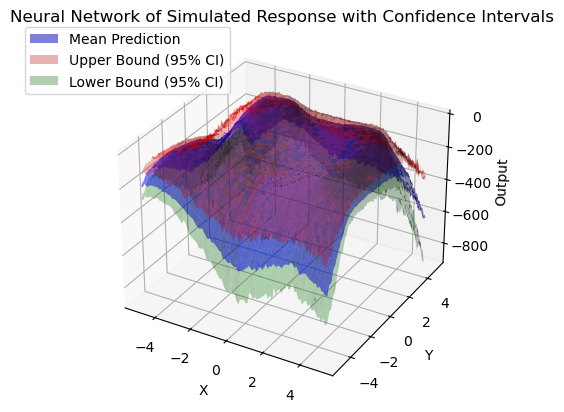

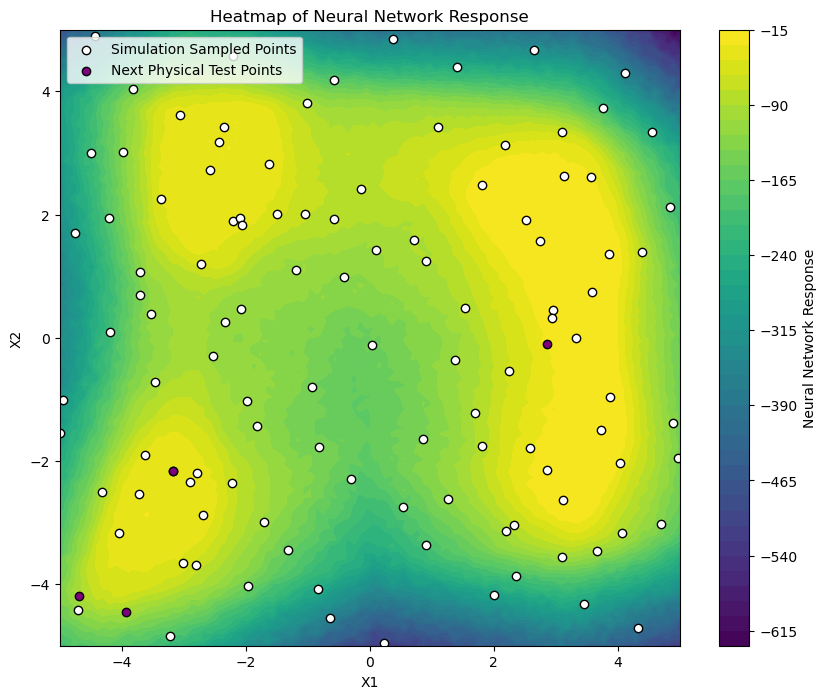

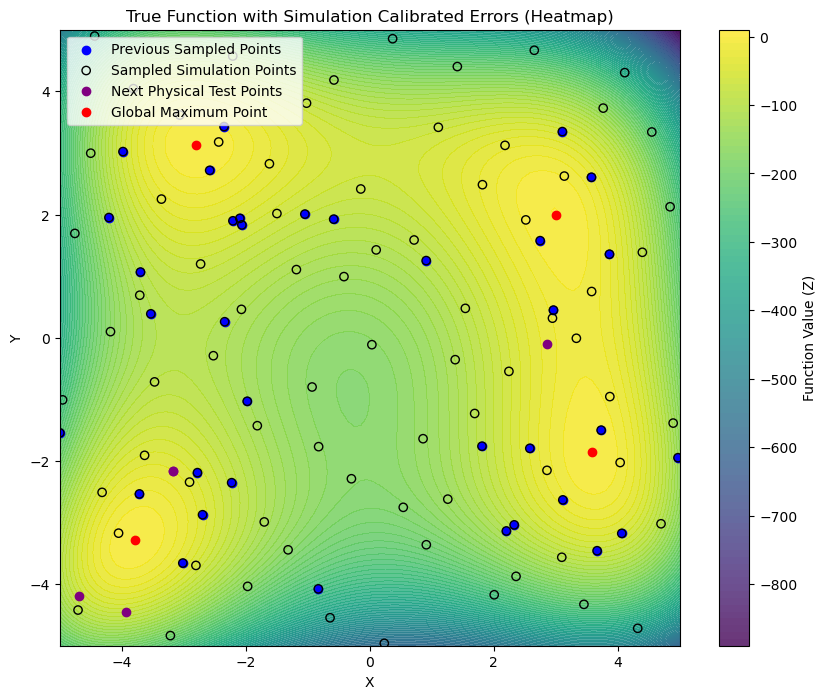

           x         y           z         a         b       sim_z      diff
0  -0.830000 -4.077000 -284.254000  4.157675 -3.000075 -284.065765 -0.188235
1   2.203000 -3.137000 -111.670000  4.157675 -3.000075 -111.732532  0.062532
2  -4.999000 -1.544000 -247.301000  4.157675 -3.000075 -247.104033 -0.196967
3  -1.977000 -1.032000 -128.723000  4.157675 -3.000075 -128.512359 -0.210641
4  -3.532000  0.388000 -111.174000  4.157675 -3.000075 -111.282965  0.108965
5  -3.715599 -2.535733  -18.449523  4.157675 -3.000075  -18.102602 -0.346921
6  -3.015836 -3.657943  -42.370777  4.157675 -3.000075  -41.819811 -0.550966
7   3.106134  3.346672  -57.324149  4.157675 -3.000075  -56.932413 -0.391736
8  -1.047407  2.006722  -78.526449  4.157675 -3.000075  -78.533402  0.006953
9  -4.206991  1.951527 -129.578588  4.157675 -3.000075 -129.781059  0.202472
10 -2.697444 -2.873441  -45.654203  4.157675 -3.000075  -45.293804 -0.360399
11 -2.207551  1.898308  -49.224003  4.157675 -3.000075  -49.373156  0.149152

In [20]:
df = perform_iteration(df)
print(df)